# All imports #

In [1]:
from __future__ import print_function

import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

from keras_uncertainty.models import MCDropoutClassifier, MCDropoutRegressor
from keras_uncertainty.utils import numpy_regression_nll


/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/d

In [2]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


In [3]:
##please select the appropriate folder, willl use os.path.join() for completed script
TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')
x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')
x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)

# Building the model with MC Droput #

In [4]:
'''

Standard deviation based data splitting

We consider the Q features and use the feature with the 

highest SD for dividing the dataset
'''

stats_q_train = pd.DataFrame()
stats_q_train["Mean"] = q_train.mean()
stats_q_train["Var"] = q_train.var()
stats_q_train["STD"] = q_train.std()
stats_q_train["OneSigmaMax"] = stats_q_train["Mean"] + stats_q_train["STD"]
stats_q_train["OneSigmaMin"] = stats_q_train["Mean"] - stats_q_train["STD"]
stats_q_train.T

max_std = stats_q_train["STD"].max()
colomn_max_std = stats_q_train["STD"].idxmax()

maximum = stats_q_train.loc[colomn_max_std, "Mean"] + (1.5 * max_std)
minimum = stats_q_train.loc[colomn_max_std, "Mean"] - (1.5 * max_std)
print(maximum, minimum)

InDistribution_Q_Train = q_train[q_train[colomn_max_std].le(maximum) & q_train[colomn_max_std].ge(minimum)]
OutDistribution_Q_Train = q_train[q_train[colomn_max_std].ge(maximum) | q_train[colomn_max_std].le(minimum)]
InDistribution_X_Train = x_train[q_train[colomn_max_std].le(maximum) & q_train[colomn_max_std].ge(minimum)]
OutDistribution_X_Train = x_train[q_train[colomn_max_std].ge(maximum) | q_train[colomn_max_std].le(minimum)]

InDistribution_Q_Test = q_test[q_test[colomn_max_std].le(maximum) & q_test[colomn_max_std].ge(minimum)]
OutDistribution_Q_Test = q_test[q_test[colomn_max_std].ge(maximum) | q_test[colomn_max_std].le(minimum)]
InDistribution_X_Test = x_test[q_test[colomn_max_std].le(maximum) & q_test[colomn_max_std].ge(minimum)]
OutDistribution_X_Test = x_test[q_test[colomn_max_std].ge(maximum) | q_test[colomn_max_std].le(minimum)]

x_train_1 = InDistribution_X_Train
q_train_1 = InDistribution_Q_Train
x_test_1 = InDistribution_X_Test
q_test_1 = InDistribution_Q_Test

OOD_x_train = OutDistribution_X_Train
OOD_q_train = OutDistribution_Q_Train
OOD_x_test = OutDistribution_X_Test
OOD_q_test = OutDistribution_Q_Test

print("//////////////////////")
print(x_train_1.shape, OOD_x_train.shape, x_test_1.shape, OOD_x_test.shape)


0.9119140506494964 -0.5558160506494813
//////////////////////
(13750, 9) (1875, 9) (3840, 9) (256, 9)


In [5]:

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

#In order training set
x_train_1 = x_scaler.fit_transform(x_train_1)
q_train_1 = q_scaler.fit_transform(q_train_1)

#complete test set
x_test = x_scaler.transform(x_test)
#q_test = q_scaler.transform(q_test)

#split testing data
IOD_x_test = x_scaler.transform(x_test_1)
IOD_q_test = q_scaler.transform(q_test_1)

OOD_x_test = x_scaler.transform(OOD_x_test)
OOD_q_test = q_scaler.transform(OOD_q_test)

In [6]:
def model_builder(input_shape, output_shape):
    def build_model(depth, width, reduction_factor):
        model = Sequential()

        for i in range(depth):
            num_neurons = max(int(width * (reduction_factor ** i)), 4)
            if i == 0:
                model.add(Dense(num_neurons, activation='relu', input_shape=(input_shape,)))
            else:
                model.add(Dense(num_neurons, activation='relu'))
                model.add(Dropout(0.5))

            model.add(BatchNormalization())

        model.add(Dense(output_shape, activation='sigmoid'))

        model.compile(loss='mse', optimizer='adam', metrics=["mae"])

        return model
    return build_model


In [7]:
HYPERPARAMETERS = {'depth': 6, 'width': 64, 'reduction_factor':  1.1}
#with tf.device('/cpu:0'):
model = model_builder(9, 18)(**HYPERPARAMETERS)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [8]:
#with tf.device('/cpu:0'):
hist = model.fit(x_train_1, q_train_1, epochs = 100, batch_size = 128, verbose = 1, validation_data=(IOD_x_test, IOD_q_test))
#use_multiprocessing=True, workers=1000

Train on 13750 samples, validate on 3840 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
13750/13750 [==============================] - 2s 122us/sample - loss: 0.1324 - mean_absolute_error: 0.2967 - val_loss: 0.1147 - val_mean_absolute_error: 0.2859
Epoch 2/100
13750/13750 [==============================] - 1s 60us/sample - loss: 0.0984 - mean_absolute_error: 0.2545 - val_loss: 0.1141 - val_mean_absolute_error: 0.2842
Epoch 3/100
13750/13750 [==============================] - 1s 60us/sample - loss: 0.0850 - mean_absolute_error: 0.2352 - val_loss: 0.0934 - val_mean_absolute_error: 0.2544
Epoch 4/100
13750/13750 [==============================] - 1s 60us/sample - loss: 0.0745 - mean_absolute_error: 0.2187 - val_loss: 0.0722 - val_mean_absolute_error: 0.2240
Epoch 5/100
13750/13750 [==============================] - 1s 60us/sample - loss: 0.0675 - mean_absolute_error: 0.2068 - val_loss: 0.0576 - val_mean_absolute_error: 0.1960
Epoch 6/100
13750/13750 [=================

13750/13750 [==============================] - 1s 60us/sample - loss: 0.0380 - mean_absolute_error: 0.1452 - val_loss: 0.0233 - val_mean_absolute_error: 0.1027
Epoch 47/100
13750/13750 [==============================] - 1s 62us/sample - loss: 0.0379 - mean_absolute_error: 0.1451 - val_loss: 0.0245 - val_mean_absolute_error: 0.1064
Epoch 48/100
13750/13750 [==============================] - 1s 61us/sample - loss: 0.0374 - mean_absolute_error: 0.1438 - val_loss: 0.0234 - val_mean_absolute_error: 0.1040
Epoch 49/100
13750/13750 [==============================] - 1s 61us/sample - loss: 0.0374 - mean_absolute_error: 0.1436 - val_loss: 0.0238 - val_mean_absolute_error: 0.1055
Epoch 50/100
13750/13750 [==============================] - 1s 62us/sample - loss: 0.0368 - mean_absolute_error: 0.1421 - val_loss: 0.0231 - val_mean_absolute_error: 0.1011
Epoch 51/100
13750/13750 [==============================] - 1s 53us/sample - loss: 0.0366 - mean_absolute_error: 0.1417 - val_loss: 0.0233 - val_mea

13750/13750 [==============================] - 1s 62us/sample - loss: 0.0310 - mean_absolute_error: 0.1250 - val_loss: 0.0210 - val_mean_absolute_error: 0.0907
Epoch 94/100
13750/13750 [==============================] - 1s 62us/sample - loss: 0.0310 - mean_absolute_error: 0.1250 - val_loss: 0.0213 - val_mean_absolute_error: 0.0924
Epoch 95/100
13750/13750 [==============================] - 1s 62us/sample - loss: 0.0308 - mean_absolute_error: 0.1247 - val_loss: 0.0207 - val_mean_absolute_error: 0.0892
Epoch 96/100
13750/13750 [==============================] - 1s 63us/sample - loss: 0.0308 - mean_absolute_error: 0.1246 - val_loss: 0.0214 - val_mean_absolute_error: 0.0923
Epoch 97/100
13750/13750 [==============================] - 1s 62us/sample - loss: 0.0309 - mean_absolute_error: 0.1248 - val_loss: 0.0217 - val_mean_absolute_error: 0.0929
Epoch 98/100
13750/13750 [==============================] - 1s 61us/sample - loss: 0.0309 - mean_absolute_error: 0.1247 - val_loss: 0.0211 - val_mea

In [9]:
q_pred = model.predict(IOD_x_test, verbose=0)
q_unnorm = q_scaler.inverse_transform(IOD_q_test)
q_pred_unnorm = q_scaler.inverse_transform(q_pred)

global_mae = mean_absolute_error(IOD_q_test, q_pred)
mae_1 = mean_absolute_error(q_unnorm, q_pred_unnorm)

print("Testing MAE: {:.5f}".format(global_mae))
print("Testing MAEX: {:.5f}".format(mae_1))


# Compute MAE for each output independently.
for i in range(IOD_q_test.shape[1]):
    norm_mae_i = mean_absolute_error(IOD_q_test[:, i], q_pred[:, i])
    mae_i = mean_absolute_error(q_unnorm[:, i], q_pred_unnorm[:, i])
    print("Q feature {} has unnorm MAE: {:.4f} (Range {:.4f} to {:.4f}) normalized MAE: {:.4f}".format(i, mae_i, q_scaler.data_min_[i], q_scaler.data_max_[i], norm_mae_i))


Testing MAE: 0.09150
Testing MAEX: 0.06371
Q feature 0 has unnorm MAE: 0.3670 (Range -0.7330 to 0.4398) normalized MAE: 0.3129
Q feature 1 has unnorm MAE: 0.3008 (Range -0.3840 to 0.5792) normalized MAE: 0.3123
Q feature 2 has unnorm MAE: 0.0317 (Range -0.8200 to -0.0680) normalized MAE: 0.0421
Q feature 3 has unnorm MAE: 0.0319 (Range -0.8381 to -0.0792) normalized MAE: 0.0421
Q feature 4 has unnorm MAE: 0.0035 (Range 0.0070 to 0.0907) normalized MAE: 0.0419
Q feature 5 has unnorm MAE: 0.0732 (Range 0.0000 to 1.0000) normalized MAE: 0.0732
Q feature 6 has unnorm MAE: 0.0030 (Range -0.0822 to 0.0000) normalized MAE: 0.0369
Q feature 7 has unnorm MAE: 0.0059 (Range 0.0000 to 0.0782) normalized MAE: 0.0760
Q feature 8 has unnorm MAE: 0.0571 (Range -0.7850 to 0.4710) normalized MAE: 0.0455
Q feature 9 has unnorm MAE: 0.0857 (Range -0.7850 to 0.4710) normalized MAE: 0.0682
Q feature 10 has unnorm MAE: 0.0610 (Range -0.5483 to 0.7767) normalized MAE: 0.0460
Q feature 11 has unnorm MAE: 0.06

# MC Dropout Regressor, O/P : mean, Std #

In [10]:
def test_mcdropout_regressor(x_test_values, q_test_values, model, data_scaler):   
    mc_model = MCDropoutRegressor(model)
    inp = x_test_values  
    
    mean, std = mc_model.predict(inp, num_samples = 10)
    
    q_pred_unnormalised = data_scaler.inverse_transform(mean)
    
    q_sd_unnromalised = data_scaler.inverse_transform(std)
    
    global_mae = mean_absolute_error(q_test_values, mean)

    print("Testing MAE: {:.5f}".format(global_mae))

    return q_pred_unnormalised, q_sd_unnromalised
  


In [11]:
'''
mean_1, std_1 = test_mcdropout_regressor(x_test, q_test, model, q_scaler)

q_test_unorm = q_scaler.inverse_transform(q_test)

print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_1, std_1**2)))
'''

'\nmean_1, std_1 = test_mcdropout_regressor(x_test, q_test, model, q_scaler)\n\nq_test_unorm = q_scaler.inverse_transform(q_test)\n\nprint("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_1, std_1**2)))\n'

In [12]:
mean_test_IOD, sd_test_IOD = test_mcdropout_regressor(IOD_x_test, IOD_q_test, model, q_scaler)
q_test_unorm = q_scaler.inverse_transform(IOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_IOD, sd_test_IOD**2)))

Testing MAE: 0.30540
NLL: 31.11246


In [13]:
mean_test_OOD, sd_test_OOD = test_mcdropout_regressor(OOD_x_test, OOD_q_test, model, q_scaler)
q_test_unorm = q_scaler.inverse_transform(OOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_OOD, sd_test_OOD**2)))

Testing MAE: 0.43475
NLL: 25.34822


-0.72872216 -0.67601234 -0.7245667 -0.68110555


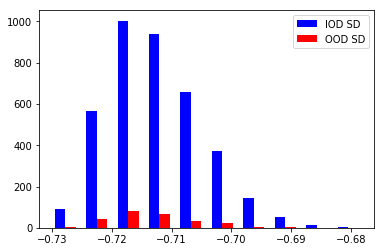

In [15]:
sd_test_IOD_df = pd.DataFrame(sd_test_IOD)
sd_test_OOD_df = pd.DataFrame(sd_test_OOD)
new_scores = np.concatenate([sd_test_IOD_df[0], sd_test_OOD_df[0]], axis=0)
new_labels = np.concatenate([np.zeros_like(sd_test_IOD_df[0]), np.ones_like(sd_test_OOD_df[0])], axis=0)
histogram_df = pd.DataFrame(new_scores, new_labels)
#print(new_scores.max())
#print(new_scores.min())
print(sd_test_IOD_df[0].min(), sd_test_IOD_df[0].max(), sd_test_OOD_df[0].min(), sd_test_OOD_df[0].max())
#histogram_df.hist(column=0)

#sd_test_IOD_df.hist(column=0)
#sd_test_OOD_df.hist(column=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(sd_test_IOD_df[0])
b_heights, b_bins = np.histogram(sd_test_OOD_df[0], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width = width, facecolor='blue',label="IOD SD")
ax.bar(b_bins[:-1]+width, b_heights, width = width, facecolor='red', label="OOD SD")
ax.legend()


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

norm_scores = new_scores - min(new_scores) / (max(new_scores) - min(new_scores))

auc = roc_auc_score(new_labels, new_scores)
fpr, tpr, threshs = roc_curve(new_labels, norm_scores, drop_intermediate=True)
print(auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.show()
